In [1]:
import sys
import os
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
import torch.nn.functional as F

sys.path.append('../python')

import models
from models import FashionCNN, simpleNN



sys.path.append('..')

In [2]:
import torchvision 
import torchvision.transforms as tt
from torchvision.datasets import FashionMNIST


data_dir='../data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# run below only if you want to claculate the mean and std, but I already did
# print("Downloading FashionMNIST data...")
# fashion_train = FashionMNIST(data_dir, train=True, download=True)
fashion_test = FashionMNIST(data_dir, train=False, download=True)

# train_long=torch.stack([tt.ToTensor()(im).view(-1) for im,_ in fashion_train])
# test_long=torch.stack([tt.ToTensor()(im).view(-1) for im,_ in fashion_test])


# train_mean = torch.mean(train_long)
# train_std = torch.std(train_long)
# test_mean = torch.mean(test_long)
# test_std = torch.std(test_long)

train_mean = 0.2860
train_std = 0.3530
test_mean = 0.2868
test_std = 0.3524

test_transform=tt.Compose([
    tt.ToTensor(), 
    tt.Normalize(mean=(test_mean,),std=(test_std,))
])

train_null_transform = tt.Compose([
    tt.ToTensor(), 
    tt.Normalize(mean=(train_mean,),std=(train_std,))
])

train_trans_transform = tt.Compose([
    tt.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    tt.ToTensor(), 
    tt.Normalize(mean=(train_mean,),std=(train_std,))
])

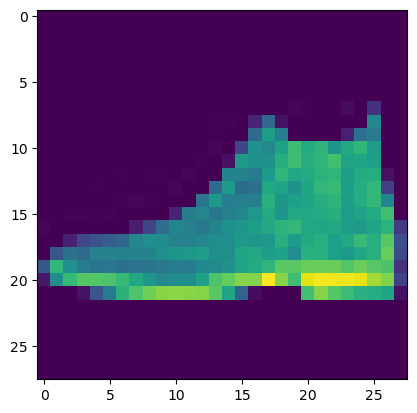

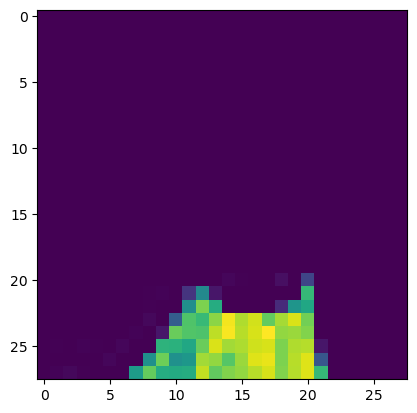

In [3]:
plt.imshow(fashion_test[0][0])
plt.show()
plt.imshow(tt.RandomAffine(degrees=0, translate=(0.5, 0.5))(fashion_test[0][0]))
plt.show()

In [4]:
LR=3e-3
WD=3e-3
epochs=2
device='mps'

torch.manual_seed(56420)

torch.manual_seed(56420)
fashion_train = FashionMNIST(data_dir, train=True, download=True, transform=train_trans_transform)
fashion_test = FashionMNIST(data_dir, train=False, download=True, transform=test_transform)

train_loader=DataLoader(fashion_train,shuffle=True, batch_size=128)
test_loader=DataLoader(fashion_test,shuffle=False, batch_size=128)


model = FashionCNN()
model.to(device)



model = FashionCNN()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

for epoch in range(epochs):
    model.train()

    epoc_loss=0.0
    for img,lbl in train_loader:
        img=img.to(device)
        lbl=lbl.to(device)
        optimizer.zero_grad()
        pred = model(img)
        loss = F.cross_entropy(pred,lbl)
        epoc_loss+=loss.item()
        loss.backward()
        optimizer.step()
    epoc_loss/=len(train_loader)

    model.eval()
    epoch_val_loss=0.0
    correct=0.0
    total=0
    for img,lbl in test_loader:
        img=img.to(device)
        lbl=lbl.to(device)
        pred = model(img)
        loss = F.cross_entropy(pred,lbl)
        epoch_val_loss+=loss.item()
        
        
        correct+= (pred.argmax(dim=1) == lbl).type(torch.float).sum().item()
        total += lbl.size(0)

        
    epoch_val_loss/=len(test_loader)
    correct/=total
    print(f'epoch: {epoch} | train loss: {epoc_loss} | val loss: {epoch_val_loss} | acc: {100*correct:.2f}')

epoch: 0 | train loss: 0.5807258575709898 | val loss: 0.402247177083281 | acc: 85.06
epoch: 1 | train loss: 0.41549843511601753 | val loss: 0.3581398446348649 | acc: 87.03


Now, the fun part. We want to penalize violation of translation invariance instead of augmenting the data to achieve translation invariance.  The way we go about it is as follows: Assume that under an infinitesimal translation the input changes from $X$ to $X + \epsilon M\cdot X$, where $M$ is the generator of translations. We want the output to remain unchanged under this transformation. This means that the output $F(X)=F(X+\epsilon M\cdot X)\sim F(X) + \epsilon [\nabla_X F(X)]^T\cdot M\cdot X$. For image translations, it is simpler to think of vertical and horizontal translations separately. Horizontal translations operate only on the rows of the image, and vertical translations operate only on the columns of the image. $M$ acts as a discrete derivative, namely $M$ takes the form

$$
M_{\rm hor} = \frac{1}{2}\begin{bmatrix}
-2 & 2 & 0 & \cdots & 0 \\
-1 & 0 & 1 & \ddots & \vdots \\
0 & -1 & 0 & 1 & 0 \\
\vdots & \ddots & \ddots & \ddots & 2 \\
0 & \cdots & 0 & -2 & 2
\end{bmatrix}
$$

The vertical translation operator $M_{\rm ver}$ is the transpose of $M_{\rm hor}$. The penalty term is then given by

$$
\mathcal{L}_{\rm sym} = \frac{\lambda}{2}\left[\left\|\nabla_X F(X)\cdot M_{\rm hor}\cdot X\right\|_2^2 + \left\|\nabla_X F(X)\cdot M_{\rm ver}\cdot X\right\|_2^2\right]
$$

In practice, it is easy to construct $M_{\rm hor}.X$ and $M_{\rm ver}.X$ using broadcasting.  





In [5]:

# # Modified loss thingy 
def get_losses(model,img,lbl):
    
    
    dif_v=torch.zeros_like(img)
    dif_v[:,:,1:-1]=img[:,:,2:]-img[:,:,:-2]
    dif_v/=2.0      
    dif_v[:,:,0]=img[:,:,1]-img[:,:,0]
    dif_v[:,:,-1]=img[:,:,-1]-img[:,:,-2]

    dif_h=torch.zeros_like(img)
    dif_h[:,:,:,1:-1]=img[:,:,:,2:]-img[:,:,:,:-2]
    dif_h/=2.0
    dif_h[:,:,:,0]=img[:,:,:,1]-img[:,:,:,0]
    dif_h[:,:,:,-1]=img[:,:,:,-1]-img[:,:,:,-2]

    img.requires_grad=True
    out=model(img)
    loss=F.cross_entropy(out,lbl)
    
    grads, =torch.autograd.grad(out,img,grad_outputs=torch.ones_like(out),create_graph=True,allow_unused=True)
    # img.requires_grad=False
    h_term=torch.einsum('ijkl,ijkl->ij',grads,dif_h).squeeze() #[0] since the shape is batch*channel*H*W, and we have a single channel
    v_term=torch.einsum('ijkl,ijkl->ij',grads,dif_v).squeeze()
    sym_loss=(h_term**2+v_term**2).mean()
    
    return loss,sym_loss



In [6]:
LR=3e-3
WD=3e-3
epochs=10
device='mps'


torch.manual_seed(56420)

torch.manual_seed(56420)
fashion_train = FashionMNIST(data_dir, train=True, download=True, transform=train_trans_transform)
fashion_test = FashionMNIST(data_dir, train=False, download=True, transform=test_transform)

train_loader=DataLoader(fashion_train,shuffle=True, batch_size=128)
test_loader=DataLoader(fashion_test,shuffle=False, batch_size=128)

model = FashionCNN()
model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

for epoch in range(epochs):
    model.train()

    epoc_loss=0.0
    for img,lbl in train_loader:
        img=img.to(device)
        lbl=lbl.to(device)
        optimizer.zero_grad()
        
        loss, symm_loss = get_losses(model,img,lbl)
        
        epoc_loss+=loss.item()
        loss+=0.051*symm_loss
        loss.backward()
        optimizer.step()
    epoc_loss/=len(train_loader)

    model.eval()
    epoch_val_loss=0.0
    correct=0.0
    total=0
    for img,lbl in test_loader:
        img=img.to(device)
        lbl=lbl.to(device)
        pred = model(img)
        loss = F.cross_entropy(pred,lbl)
        epoch_val_loss+=loss.item()
        
        
        correct+= (pred.argmax(dim=1) == lbl).type(torch.float).sum().item()
        total += lbl.size(0)

        
    epoch_val_loss/=len(test_loader)
    correct/=total
    print(f'epoch: {epoch} | train loss: {epoc_loss} | val loss: {epoch_val_loss} | acc: {100*correct:.2f}')

epoch: 0 | train loss: 0.8288178387989622 | val loss: 0.5319499520561363 | acc: 82.28
epoch: 1 | train loss: 0.5871578880718776 | val loss: 0.505652428427829 | acc: 82.67
epoch: 2 | train loss: 0.5500655622243373 | val loss: 0.4919432801536367 | acc: 83.98
epoch: 3 | train loss: 0.5313281301877646 | val loss: 0.49400046807301196 | acc: 80.81
epoch: 4 | train loss: 0.5161819858337516 | val loss: 0.4659710579280612 | acc: 85.12
epoch: 5 | train loss: 0.506743979606547 | val loss: 0.4401211553736578 | acc: 85.73
epoch: 6 | train loss: 0.4964753823366755 | val loss: 0.46515561357329166 | acc: 83.95
epoch: 7 | train loss: 0.489790220250453 | val loss: 0.4527797321730022 | acc: 84.74
